In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder  
from torchvision import models
from torch import optim
%matplotlib inline

In [2]:
data_dir = "../input/plant disease regonition"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
diseases = os.listdir(train_dir)
print(diseases)
print(len(diseases))

['Healthy', 'Powdery', 'Rust']
3


In [3]:
transform= transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
batch_size = 64
train = ImageFolder(train_dir, transform=transform)
valid = ImageFolder(valid_dir, transform=transform) 
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [5]:
model = models.vgg16(pretrained=True)

In [6]:
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(25088, 4096),
                          nn.Dropout(p = 0.5),
                          nn.BatchNorm1d(num_features=4096),
                          nn.ReLU(),
                          nn.Linear(4096, 1024),
                          nn.Dropout(p = 0.5),
                          nn.BatchNorm1d(num_features=1024),
                          nn.ReLU(),
                          nn.Linear(1024, 3))
    
model.classifier = classifier

In [7]:
learning_rate = 0.0001
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [8]:
criterion = nn.CrossEntropyLoss()
# set optimizer, only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)

In [9]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
total_step = len(train_dl)
total_step = len(train_dl)
num_epoch = 10
List_acc_valid=[]
List_acc_train=[]  
List_loss_valid=[]
List_loss_train=[]
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 21 == 20:    # print every 1000 mini-batches
            correct_train = 0
            total_train = 0
            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            acc_train = 100 * correct_train/total_train
            running_loss = 0.0
            print ('Epoch [{}/{}], Step [{}/{}], Accuracy: {}%, Loss: {:.4f}'.format(epoch+1, num_epoch, i+1, total_step, acc_train, loss.item()))
    
    correct = 0
    total = 0
    model.eval()
    total_loss_per_epoch = 0
    with torch.no_grad():
        for i, data in enumerate(valid_dl):
            images_valid, labels_valid = data[0].to(device), data[1].to(device)
            outputs_valid = model(images_valid)
            loss_valid = criterion(outputs_valid, labels_valid)
            total_loss_per_epoch += loss_valid.item()
            _, predicted = torch.max(outputs_valid.data, 1)
            total += labels_valid.size(0)
            correct += (predicted == labels_valid).sum().item()
            acc_valid = 100 * correct / total
        loss_per_epoch = total_loss_per_epoch/i    
        print('Accuracy: %.2f %%' % (100 * correct / total))
        print(loss_per_epoch)
        
        List_acc_valid.append(acc_valid)
        List_acc_train.append(acc_train)
        List_loss_valid.append(loss_valid.item())
        List_loss_train.append(loss.item()) 
print('Finished Training of VGG-16')

C:\Users\Yueqiao\anaconda3\envs\ttorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/10], Step [21/21], Accuracy: 97.61904761904762%, Loss: 0.1129
Accuracy: 93.33 %
0.3756435960531235
Epoch [2/10], Step [21/21], Accuracy: 97.61904761904762%, Loss: 0.0853
Accuracy: 92.67 %
0.46328217536211014
Epoch [3/10], Step [21/21], Accuracy: 97.61904761904762%, Loss: 0.0696
Accuracy: 92.67 %
0.45205262303352356
Epoch [4/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0190
Accuracy: 93.33 %
0.4455779641866684
Epoch [5/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0056
Accuracy: 93.33 %
0.43350015580654144
Epoch [6/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0050
Accuracy: 93.33 %
0.42331457883119583
Epoch [7/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0078
Accuracy: 93.33 %
0.4145335927605629
Epoch [8/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0021
Accuracy: 93.33 %
0.39248815923929214
Epoch [9/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0028
Accuracy: 93.33 %
0.39641619473695755
Epoch [10/10], Step [21/21], Accuracy: 100.0%, Loss: 0.0028
Accuracy: 93.33 %
0.38867418467998

In [11]:
dataiter = iter(train_dl)
images, labels = dataiter.next()
classes = ('Healthy', 'Powdery', 'Rust')

In [12]:
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))
with torch.no_grad():
    for data in valid_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(22):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(3):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Healthy : 100 %
Accuracy of Powdery : 100 %
Accuracy of  Rust : 86 %


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in valid_dl:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %.2f %%' % (100 * correct / total))

Accuracy: 93.33 %


 Accuracy for train dataset:100.00%
 Accuracy for valid dataset:93.33%




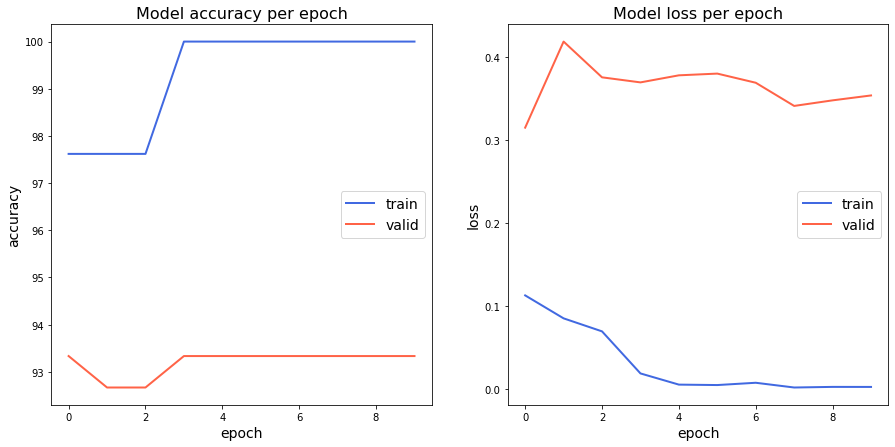

In [14]:
#Train and Valid Accuracy & Loss curve
#-------------------------------------------------------------------------------
print('\033[1m Accuracy for train dataset:{:.2f}%\033[0m'.format(List_acc_train[-1]))
print('\033[1m Accuracy for valid dataset:{:.2f}%\033[0m'.format(List_acc_valid[-1]))
print('\n')

#Accuracy curves
#-------------------------------------------------------------------------------
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.plot(List_acc_train,"royalblue",linewidth=2)
plt.plot(List_acc_valid,"tomato",linewidth=2)
plt.title('Model accuracy per epoch',fontsize=16)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)

#Loss curves
#-------------------------------------------------------------------------------
plt.subplot(122)
plt.plot(List_loss_train,"royalblue",linewidth=2)
plt.plot(List_loss_valid,"tomato",linewidth=2)
plt.title('Model loss per epoch',fontsize=16)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train', 'valid'], loc='right',fontsize=14)
plt.show()

In [17]:
PATH = './plant3_VGG16_full.pth'
torch.save(model, PATH)

In [18]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Ti'